# PyAtomDB - what is it?</h1>

PyAtomDB interacts with the AtomDB atomic database. So first, a quick description of AtomDB. AtomDB is primarily targeted at modeling X-ray emission from collisionally ionized astrophysical plasma. (10^4 < T < 10^9 K). It is a combination of several components:
* An Atomic Database (APED)
* An "Plasma Code" (APEC)
* Other assorted models
* <font color="red">Connections to spectral analysis tools</font>
<hr/>










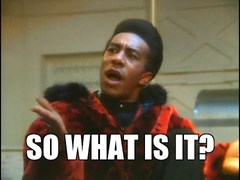
           

<h2> The APED Atomic Database</h2>
<ul>
    <li>large collection of FITS files covering different atomic data for all ions from H I to Ni XXVIII, and some more up to Zn.</li>
</ul>
  
    

![directorystruct.png](directorystruct.png)

<p>Different files for different data types
    <ul>
        <li>IR: Ionization and Recomination Rates</li>
        <li>LV: Energy Levels</li>
        <li>LA: Wavelengths and Transition Probabilities</li>
        <li>EC: Electron Collisions</li>
        <li>PC: Proton Collisions</li>
        <li>DR: Dielectronic Recombination Satellite Lines</li>
        <li>AI: Autoionization Rates</li>
        <li>PI: Photoionization Cross Sections</li>
    </ul>
Plus additional files for Abundances</p>
        

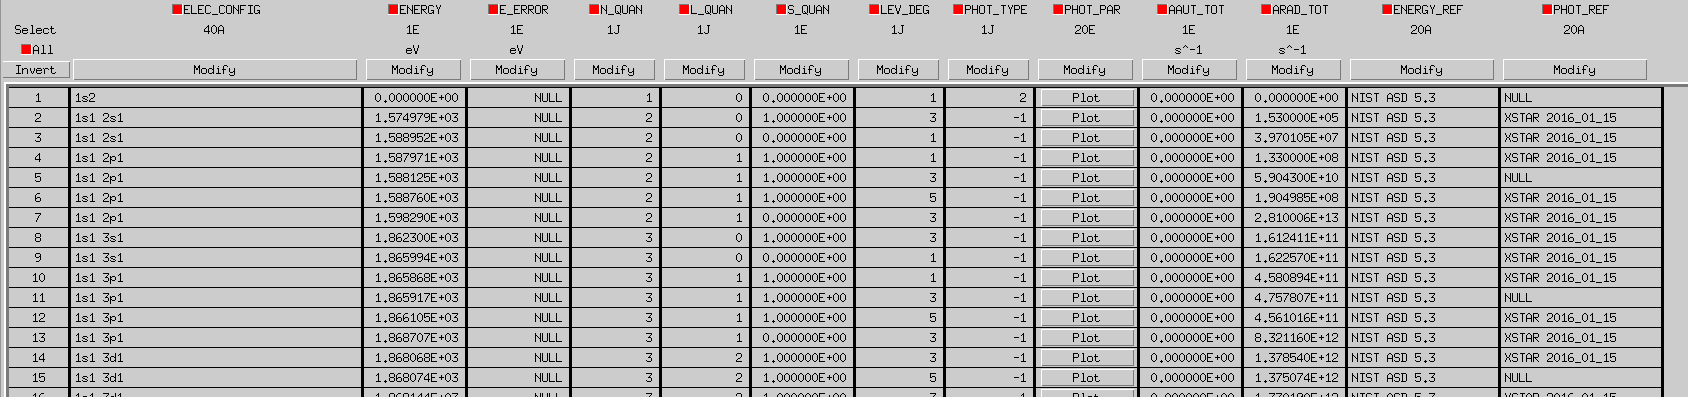

<h2> Online Access: Webguide</h2>
<p>There is limited online access to the database to find energies, levels, transitions, etc. See here:

[AtomDB Webguide](http://www.atomdb.org/Webguide)
</p>

# PyAtomDB

One stop shop for all AtomDB things:

* Access to atomic database
* All model code for turning database into emissivities
* Generating spectra

## Installation

If you have pip installed:

``pip install pyatomdb``

Note, that if you don't have admin permissions, adding --user will install in your local tree

``pip install pyatomdb --user``

Alternatively, the [Github Version](https://github.com/AtomDB/pyatomdb) updates more frequently. clone, unzip then run
``python setup.py install`` or ``python setup.py install --user`` as appropriate.

As of November 21st 2018, python 2.7 support has been suspended. There is still a GitHub branch for this if required, but Python 3 is now the defaul version.

## Initialization

One installed, you must initalize the database by calling from the python interpreter:

``import pyatomdb
pyatomdb.util.initialize()``

This should install the files if you follow the on screen instructions. You only need to do this once, not each time you restart pyatomdb. Code below will do this for you.




In [ ]:
# NOTE ONLY RUN THIS IF YOU HAVE TO:
# If this is your first installation of pyatomdb
# It will download ~0.5GB of data files
# (It won't break anything to do it again, but you will have an extra 500MB of downloads to do...)

import pyatomdb
pyatomdb.util.initialize()

## Accessing the Atomic Database

Let's get some data on He-like oxygen

In [ ]:
import pyatomdb, numpy
# get the energy level data. Will download files on demand if required.
a = pyatomdb.atomdb.get_data(8, 7, 'LV')

# data is in FITS files, so all the data is in HDU 1 (a[1].data, in this case)
print(a[1].data.dtype)
print('\n\n')
# print details of the first 5 levels
print("Config    Energy (eV)  S  L g")
for aa in a[1].data[:5]:
    print("%-10s %10.4f %.1f %1i %1i"%(aa['ELEC_CONFIG'], aa['ENERGY'], aa['S_QUAN'],aa['L_QUAN'], aa['LEV_DEG']))

In [ ]:
# now lets find an effective collision strength
Te = numpy.logspace(0.01,2.0,10) # keV
initlev = 1
finallev = 7
Z=8
z1 = 7
dtype='EC'
exc, dex = pyatomdb.atomdb.get_maxwell_rate(Te, dtype=dtype, initlev = initlev, \
                                            finallev=finallev, Te_unit='keV', Z=Z, z1=z1 )


In [ ]:
# some plotting setup
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.loglog(Te, exc)
plt.xlabel('kT (kev)')
plt.ylabel('Eff Coll Str (cm$^3$ s$^{-1}$)')
plt.tight_layout()
plt.show()


# Making Spectra 

Calculate a spectrum and fold it through an instrument response

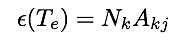
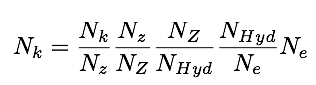

In [ ]:
s = pyatomdb.spectrum.Session()
ebins = numpy.linspace(1,30,901)
s.set_specbins(ebins, specunits='A')

# get the spectrum at kT=1keV

spec1 = s.return_spectra(1.0)

# plotting

plt.figure()
plt.plot(ebins, numpy.append(0, spec1), drawstyle='steps')
plt.xlabel('Wavelength (A)')
plt.ylabel('Emissivity (ph cm$^3$ s$^{-1}$ bin$^{-1}$)')
plt.tight_layout()
plt.show()

In [ ]:
# Halve the oxygen
s.set_abund(8,0.5)
spec2 = s.return_spectra(1.0)
plt.plot(ebins, numpy.append(0, spec2), drawstyle='steps')
plt.show()

In [ ]:
s2 = pyatomdb.spectrum.Session()
s2.set_response('aciss_heg1_cy19.grmf', arf='aciss_heg1_cy19.garf')
spec3 = s2.return_spectra(1.0)
# NOTE THIS TAKES ~ 1 minute

In [ ]:
plt.figure()
plt.plot(12.398425/s2.ebins_response[::-1], numpy.append(0, spec3), drawstyle='steps')
plt.xlabel('Wavelength (A)')
plt.ylabel('Emissivity (ph cm$^3$ s$^{-1}$ bin$^{-1}$)')
plt.tight_layout()
plt.show()


In [ ]:
#get individual line emissivities vs temperature

emiss = pyatomdb.atomdb.get_line_emissivity(26,25,2,1)
plt.figure()
plt.loglog(emiss['kT'], emiss['epsilon'], label='Equilib')
emiss = pyatomdb.atomdb.get_line_emissivity(26,25,2,1, use_nei_raw=True)
for z1 in emiss['epsilon'].keys():
    plt.loglog(emiss['kT'], emiss['epsilon'][z1], label='Fe %i'%(z1))

plt.xlabel('Temperature (keV)')
plt.ylabel('Emissivity (ph cm$^3$ s$^{-1}$)')
plt.title("Contribution to Fe XXV forbidden line (2-1) by parent ion")
plt.legend(loc=0)

plt.tight_layout()
plt.show()


# Integration into Modeling Codes

Our codes are written in python, for easy access and development. Most users want only the emissivities, and they want them to run fast in an fitting loop. As such, our emissivity files can be read in by XSPEC for this and other models.

In [ ]:
import xspec

#spectrum
s1 = xspec.Spectrum('testacx_99.pha')

#model
m1 =xspec.Model('tbabs*vrnei')

#thaw the oxygen content
m1.vrnei.O.frozen=False
m1.vrnei.kT=0.7
m1.vrnei.kT_init=0.7
m1.show()


#set some plot parameters
xspec.Plot.device='/null'
xspec.Plot.xAxis='keV'
xspec.Plot('data')
xspec.Plot.perHz=False
# make the figures

plt.figure()
plt.loglog(xspec.Plot.x(), xspec.Plot.y(), 'r.', label='data')
plt.loglog(xspec.Plot.x(), xspec.Plot.model(), label='init model')

# fit the data
xspec.Fit.perform()


# plot the results
xspec.Plot('data')

plt.loglog(xspec.Plot.x(), xspec.Plot.model(), label='final model')


plt.xlabel('Photon Energy (keV)')
plt.ylabel('Intensity (ph cm$^{-2}$ s$^{-1}$)')
plt.legend(loc=0)
plt.tight_layout()

plt.show()


## Incorporating our models into XSPEC: ACX

In [ ]:
import vvacx
xspec.Xset.restore('oxygencx.mdl')
m1=xspec.AllModels(1)

In [ ]:
# adjust velocity to see differences
y={}
celist = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0] #keV/amu
plt.figure()
offset=0.00

for ce in celist:
    m1.xspecvvacx.collenergy=ce
    xspec.Plot('Model')
    y[ce] = xspec.Plot.model()
    plt.plot(numpy.array(xspec.Plot.x())+offset, numpy.array(y[ce])/max(numpy.array(y[ce])), label=repr(ce))
    offset+=0.001
    print(ce, max(numpy.array(y[ce])))
plt.legend(loc=0)
plt.xlabel('Energy (keV)')
plt.ylabel('Normalized Intensity')

plt.show()